# <h1><center>**SEISMIC ANALYSIS AND INVERSION - GEO670**</center></h1>

## <h1><center>**MACHINE LEARNING GROUP EXCERCISE**</center></h1>

## <h1><center>LITHOFACIES PREDICTION BY USING WELL LOGS</center></h1>

By: Edward Dontoh,
John Masapantah,
Orlando Butar Butar

## **IMPORTING LIBRARIES**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import confusion_matrix
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from itertools import product
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
import warnings 
warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
#Connecting notebook to google drive - run it if your data is stored on your google drive
from google.colab import drive  
drive.mount('/content/drive')

Mounted at /content/drive


## **NEEDED FUNCTIONS**

In [ ]:
#Raw logs plotting
def raw_logs(logs, well_num):

  """Plots the raw logs contained in the original datasets after they have been formated.
  Parameters
  ----------
  logs: dataframe
    The raw logs once the headers and necessary columns have been formated and fixed.
  well_num: int
    The number of the well to be plotted. raw_logs internally defines a list of weells 
    contained by the dataset, each of them could be called by its list index.
  Returns
  ----------
  plot:
    Different tracks having one well log each and a final track containing the 
    lithofacies interpretation.
  """

  facies_colors = ['#F4D03F','#7ccc19','#196F3D','#160599','#2756c4','#3891f0','#80d4ff','#87039e','#ec90fc','#FF4500','#000000','#DC7633']
  facies_labels = ['SS', 'S-S', 'SH', 'MR', 'DOL','LIM', 'CH','HAL', 'AN', 'TF', 'CO', 'BS']

  facies_color_map = {} # creating facies color map
  for ind, label in enumerate(facies_labels):
      facies_color_map[label] = facies_colors[ind]

  wells = logs['WELL'].unique() # creating a wells list
  logs = logs[logs['WELL'] == wells[well_num]] # selecting well by index number
  logs = logs.sort_values(by='DEPTH_MD') # sorting well log by depth
  cmap_facies = colors.ListedColormap(facies_colors[0:len(facies_colors)], 'indexed')
  
  top = logs.DEPTH_MD.min()
  bot = logs.DEPTH_MD.max()
  
  real_label = np.repeat(np.expand_dims(logs['LITHO'].values, 1), 100, 1)

  f, ax = plt.subplots(nrows=1, ncols=17, figsize=(20, 12))
  log_colors = ['black', 'red', 'blue', 'green', 'purple']*10

  for i in range(7,23):
    ax[i-7].plot(logs.iloc[:,i], logs.DEPTH_MD, color=log_colors[i]) # plotting each well log on each track
    ax[i-7].set_ylim(top, bot)
    ax[i-7].set_xlabel(str(logs.columns[i]))
    ax[i-7].invert_yaxis()
    ax[i-7].grid()

  im = ax[-1].imshow(real_label, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=12)
  ax[-1].set_xlabel('LITHO') # creating a facies log on the final track

  divider = make_axes_locatable(ax[-1]) # appending legend besides the facies log
  cax = divider.append_axes("right", size="20%", pad=0.05)
  cbar=plt.colorbar(im, cax=cax)
  cbar.set_label((12*' ').join(['SS', 'S-S', 'SH', 'MR', 'DOL','LIM', 'CH','HAL', 'AN', 'TF', 'CO', 'BS']))
  
  cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
      
  f.suptitle('WELL LOGS '+str(wells[well_num]), fontsize=16,y=0.9)


#Predictions plot
def litho_prediction(logs, well_num, n_pred):
  
  """Plots the raw logs, the lihtology interpretation, and the n_pred number of predcted 
  lithologies by machine learning.
  Parameters
  ----------
  logs: dataframe
    Dataframe holding the raw wireline logs, true lithology, and n_pred columns 
    containing different ML model predictions each.
  well_num: int
    The number of the well to be plotted. litho_prediction internally defines a list of 
    weells contained by the logs dataframe, each of which could be called by its list index.
  Returns
  ----------
  plot:
    Different track plots representing each wireline log, the true lihtology and the 
    predicted lithologies by dfferent mane-learning models.
  """

  facies_colors = ['#F4D03F','#7ccc19','#196F3D','#160599','#2756c4','#3891f0','#80d4ff','#87039e','#ec90fc','#FF4500','#000000','#DC7633']
  facies_labels = ['SS', 'S-S', 'SH', 'MR', 'DOL','LIM', 'CH','HAL', 'AN', 'TF', 'CO', 'BS']

  facies_color_map = {} #creating facies coorap

  for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

  wells = logs['WELL'].unique() # well names list
  logs = logs[logs['WELL'] == wells[well_num]]
  logs = logs.sort_values(by='DEPTH_MD') # sorting the plotted well logs by depth       
  cmap_facies = colors.ListedColormap(facies_colors[0:len(facies_colors)], 'indexed')
  
  top = logs.DEPTH_MD.min()
  bot = logs.DEPTH_MD.max()
      
  f, ax = plt.subplots(nrows=1, ncols=(12+n_pred), figsize=(20, 12))
  log_colors = ['black', 'red', 'blue', 'green', 'purple']*10

  for i in range(7,18):
    ax[i-7].plot(logs.iloc[:,i], logs.DEPTH_MD, color=log_colors[i]) # plotting continuous wireline logs
    ax[i-7].set_ylim(top, bot)
    ax[i-7].set_xlabel(str(logs.columns[i]))
    ax[i-7].invert_yaxis()
    ax[i-7].grid()

  for j in range((-1-n_pred), 0): # ploting the lithology predictions obtainedby ML
    label = np.repeat(np.expand_dims(logs.iloc[:,j].values, 1), 100, 0)
    im = ax[j].imshow(label, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=12)
    ax[j].set_xlabel(str(logs.columns[j]))

  divider = make_axes_locatable(ax[-1]) # appending lithology legend
  cax = divider.append_axes("right", size="20%", pad=0.05)
  cbar=plt.colorbar(im, cax=cax)
  cbar.set_label((12*' ').join(['SS', 'S-S', 'SH', 'MR', 'DOL','LIM', 'CH','HAL', 'AN', 'TF', 'CO', 'BS']))
  cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
      
  f.suptitle('WELL LOGS '+str(wells[well_num]), fontsize=14,y=0.94)


# Normalized confusion matrix 
def litho_confusion_matrix(y_true, y_pred):

  """Plots a confusion matrix normalized by the number of predictions a particular
  machine learning algorithm has. By ormalize we look at the number of predictions
  the model gets right.
  Parameters
  ----------
  y_true: list
    The actual lithologies given by the datasets provider.
  y_pred: list
    The predicted lithofacies obtained by a particular machine learning model.
  Returns
  ----------
  confusion matrix:
    A normalized confusion matrix by the number of predictions. 
  """

  facies_dict = {0:'Sandstone', 1:'Sandstone/Shale', 2:'Shale', 3:'Marl',
                 4:'Dolomite', 5:'Limestone', 6:'Chalk', 7:'Halite', 
                 8:'Anhydrite', 9:'Tuff', 10:'Coal', 11:'Basement'}

  labels = list(set(list(y_pred.unique()) + list(y_true.unique())))
  label_names = [facies_dict[k] for k in labels]

  #Normalizing confusion matrix
  cm = pd.DataFrame(confusion_matrix(y_true.values, y_pred.values))
  summ = cm.sum(axis=0)
  cm_norm = pd.DataFrame(np.zeros(cm.shape))
  for i in range(cm.shape[1]):
    for j in range(cm.shape[0]):
      cm_norm[i][j] = cm[i][j]*100/summ[i]

  cm_final = cm_norm.fillna(0).to_numpy()

  #disp = ConfusionMatrixDisplay(confusion_matrix=cm_final, display_labels=labels)
  fig, ax = plt.subplots(figsize=(12,8))
  plt.imshow(cm_final, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('NORMALIZED CONFUSION MATRIX', size=15)
  tick_marks = np.arange(len(label_names))
  plt.xticks(tick_marks, label_names, rotation=90)
  plt.yticks(tick_marks, label_names)
  plt.colorbar()
      
  fmt = '.2f'
  thresh = cm_final.max() / 2.
  for i, j in product(range(cm_final.shape[0]),   range(cm_final.shape[1])):
    plt.text(j, i, format(cm_final[i, j], fmt),
                  horizontalalignment="center",
                  color="white" if cm_final[i, j] > thresh else "black")
          
  plt.ylabel('True label', size=14)
  plt.xlabel('Predicted label', size=14)


## **1. LOADING AND FORMATING DATA**

In [ ]:
#Datsasets paths 
traindata_path = '/content/drive/MyDrive/train.csv'
testdata_path = '/content/drive/MyDrive/test.csv'
testlabels_path = '/content/drive/MyDrive/test_target.csv'
hiddendata_path = '/content/drive/MyDrive/hidden_test.csv'

#Training dataset
labeled_data = pd.read_csv(traindata_path, sep=';')
labeled_data = labeled_data.rename(columns={'FORCE_2020_LITHOFACIES_LITHOLOGY':'LITHO', 'FORCE_2020_LITHOFACIES_CONFIDENCE':'LIT_CONF'})
labeled_data = labeled_data.drop(['LIT_CONF'], axis=1)

#Test dataset
unlabeled_data = pd.read_csv(testdata_path, sep=';')
labels = pd.read_csv(testlabels_path, sep=';')
test_data = pd.merge(unlabeled_data, labels, on=['WELL', 'DEPTH_MD'])
test_data = test_data.rename(columns={'FORCE_2020_LITHOFACIES_LITHOLOGY':'LITHO'})

#Hidden dataset
hidden_data = pd.read_csv(hiddendata_path, sep=';')
hidden_data = hidden_data.rename(columns={'FORCE_2020_LITHOFACIES_LITHOLOGY':'LITHO'})
hidden_data = hidden_data.drop(['FORCE_2020_LITHOFACIES_CONFIDENCE'], axis=1)

#Mapping lithologies with values from 0 to 10
lithology_numbers = {
                     30000: 0, 65030: 1,
                     65000: 2, 80000: 3,
                     74000: 4, 70000: 5,
                     70032: 6, 88000: 7,
                     86000: 8, 99000: 9,
                     90000: 10, 93000: 11
                     }

labeled_data['LITHO'] = labeled_data["LITHO"].map(lithology_numbers)
test_data['LITHO'] = test_data["LITHO"].map(lithology_numbers)
hidden_data['LITHO'] = hidden_data['LITHO'].map(lithology_numbers)

print('Train data contains: {} data points'.format(labeled_data.shape))
print('Test data contains: {} data points'.format(test_data.shape))
print('Hidden data contains: {} data points'.format(hidden_data.shape))

Train data contains: (1170511, 28) data points
Test data contains: (136786, 28) data points
Hidden data contains: (122397, 28) data points


## **2. DATA DESCRIPTION AND FIRST INSPECTION**

The data contains the metadata columns
* WELL: well name
* DEPTH_MD: measured depth
* X_LOC: UTM X coordinate 
* Y_LOC: UTM Y coordinate
* Z_LOC: DEPTH
* GROUP: NPD lithostratigraphy group
* FORMATION: NPD lithostratgraphy formation

The data contains the well log curves. For example the following:
* BS: Bit Size
* CALI: Caliper
* RDEP: Deep Resistivity
* RHOB: Bulk Density
* GR: Raw gamma data
* SGR: Spectral Gamma Ray
* RMED: Medium Resistivity
* ROP: Rate of Penetration
* NPHI: Neutron Porosity
* PEF: Photoelectric Absorption Factor
* RSHA: Shallow Resistivity
* DTS: Sonic (Sheer Slowness)
* DTC: Sonic (Compressional Slowness)

See contest page for full list.

as well as the interpretation

* LITHO: lithology class label

In [ ]:
#Inspecting wells available in the training dataset
labeled_wells = labeled_data['WELL'].unique()
print(labeled_wells)

['15/9-13' '15/9-15' '15/9-17' '16/1-2' '16/1-6 A' '16/10-1' '16/10-2'
 '16/10-3' '16/10-5' '16/11-1 ST3' '16/2-11 A' '16/2-16' '16/2-6' '16/4-1'
 '16/5-3' '16/7-4' '16/7-5' '16/8-1' '17/11-1' '25/11-15' '25/11-19 S'
 '25/11-5' '25/2-13 T4' '25/2-14' '25/2-7' '25/3-1' '25/4-5' '25/5-1'
 '25/5-4' '25/6-1' '25/6-2' '25/6-3' '25/7-2' '25/8-5 S' '25/8-7' '25/9-1'
 '26/4-1' '29/6-1' '30/3-3' '30/3-5 S' '30/6-5' '31/2-1' '31/2-19 S'
 '31/2-7' '31/2-8' '31/2-9' '31/3-1' '31/3-2' '31/3-3' '31/3-4' '31/4-10'
 '31/4-5' '31/5-4 S' '31/6-5' '31/6-8' '32/2-1' '33/5-2' '33/6-3 S'
 '33/9-1' '33/9-17' '34/10-19' '34/10-21' '34/10-33' '34/10-35' '34/11-1'
 '34/11-2 S' '34/12-1' '34/2-4' '34/3-1 A' '34/4-10 R' '34/5-1 A'
 '34/5-1 S' '34/7-13' '34/7-20' '34/7-21' '34/8-1' '34/8-3' '34/8-7 R'
 '35/11-1' '35/11-10' '35/11-11' '35/11-12' '35/11-13' '35/11-15 S'
 '35/11-6' '35/11-7' '35/12-1' '35/3-7 S' '35/4-1' '35/8-4' '35/8-6 S'
 '35/9-10 S' '35/9-2' '35/9-5' '35/9-6 S' '36/7-3' '7/1-1' '7/1-2 S']


In [ ]:
#Number of wells contained in the train dataset
print("The training data contains {} wells".format(len(labeled_wells)))

The training data contains 98 wells


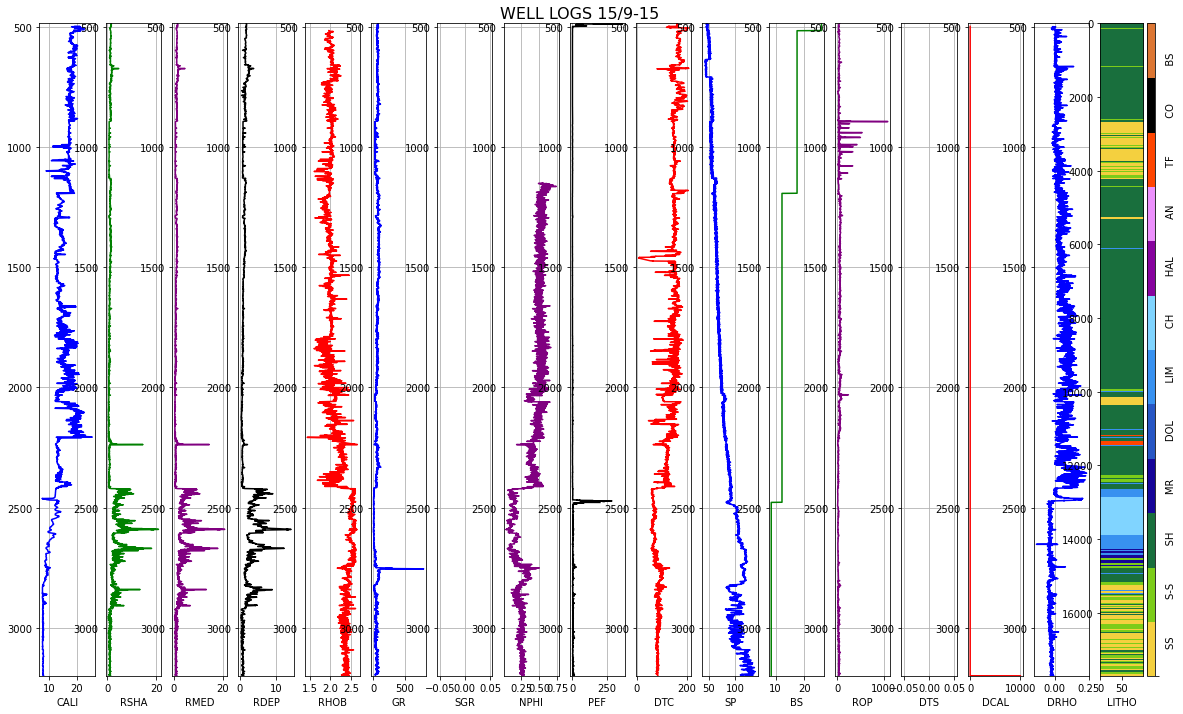

In [ ]:
#Plotting raw training data - well index = 0
raw_logs(labeled_data, 1)

### 2A. Labels Distributions

In [ ]:
lithology_numbers2 = {0:'Sandstone', 1:'Sandstone/Shale', 2:'Shale', 
                     3:'Marl', 4:'Dolomite', 5:'Limestone', 6:'Chalk', 
                     7:'Halite', 8:'Anhydrite', 9:'Tuff', 10:'Coal', 11:'Basement'}

train_label_dict = dict(labeled_data['LITHO'].map(lithology_numbers2).value_counts())
train_label_counts = {key:np.round(value*100/labeled_data['LITHO'].count(), 1) for key, value in train_label_dict.items()}

test_label_dict = dict(test_data['LITHO'].map(lithology_numbers2).value_counts())
test_label_counts = {key:np.round(value*100/test_data['LITHO'].count(), 1) for key, value in test_label_dict.items()}

hidden_label_dict = dict(hidden_data['LITHO'].map(lithology_numbers2).value_counts())
hidden_label_counts = {key:np.round(value*100/hidden_data['LITHO'].count(), 1) for key, value in hidden_label_dict.items()}

total_conts = {'TRAIN':train_label_counts,
               'TEST':test_label_counts,
               'HIDDEN': hidden_label_counts}

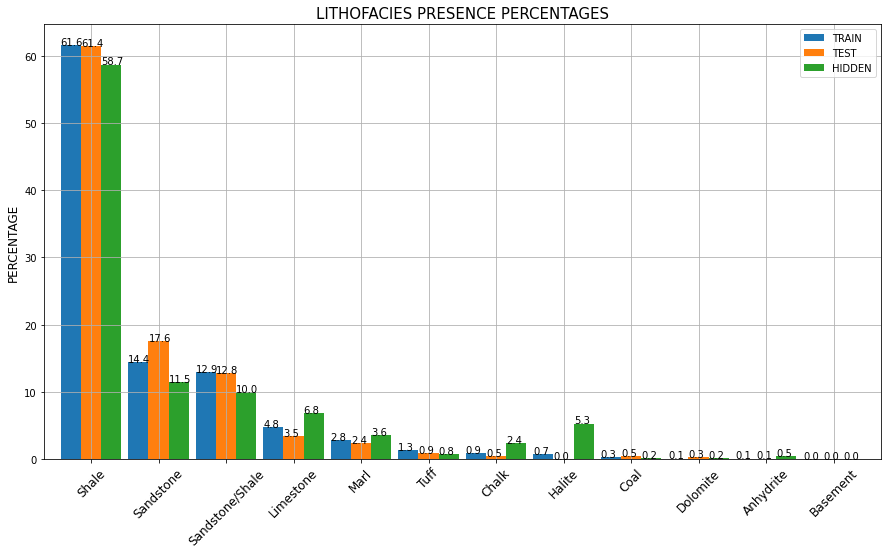

In [ ]:
#Plotting Histograms
ax = pd.DataFrame(total_conts).plot(kind='bar', figsize=(15,8), legend=True, width=0.9)
ax.set_title('LITHOFACIES PRESENCE PERCENTAGES', size=15)
ax.set_ylabel('PERCENTAGE', size=12)
plt.xticks(size=12, rotation=45, )
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height()), size=10)
plt.grid(True)
plt.show()

### 2B. Features Percentages in Datasets

**Notice that some of the curves are NaN. This is an imporant aspect of this dataset and of this competition.** The only log columns that are **guaranteed** to be present are WELL, DEPT, and GR. All other logs can (and will) be missing from some parts of the dataset.

The following plot shows how large a percentage of training data wells contain at least some depth interval with the given logs. As you can see a couple of logs like RT and DTS are present in less than half of the training wells. **Remember, the test data will have a similar distribution of available logs**

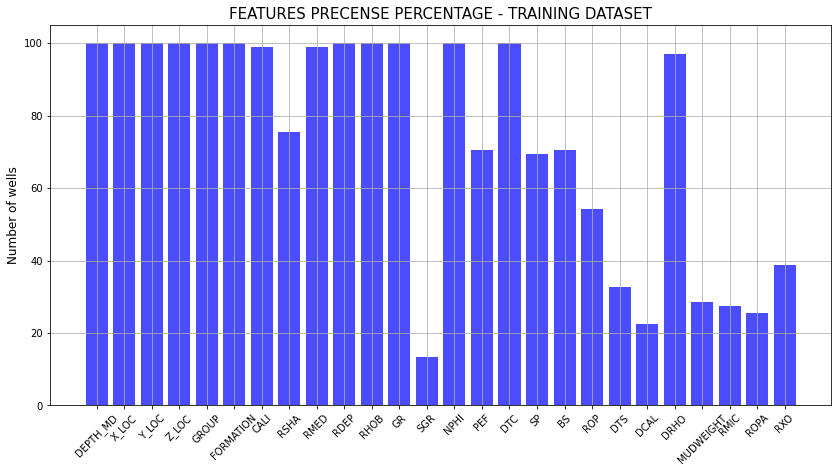

In [ ]:
occurences = np.zeros(26)
for well in labeled_data['WELL'].unique():
    occurences += labeled_data[labeled_data['WELL'] == well].isna().all().astype(int).values[1:-1]
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.bar(x=np.arange(occurences.shape[0]), height=(labeled_data.WELL.unique().shape[0]-occurences)/labeled_data.WELL.unique().shape[0]*100.0, color='b', alpha=0.7)
ax.set_xticklabels(labeled_data.columns[1:-1], rotation=45)
ax.set_xticks(np.arange(occurences.shape[0]))
ax.set_ylabel('Number of wells', size=12)
ax.set_title("FEATURES PRECENSE PERCENTAGE - TRAINING DATASET", size=15)
ax.grid()

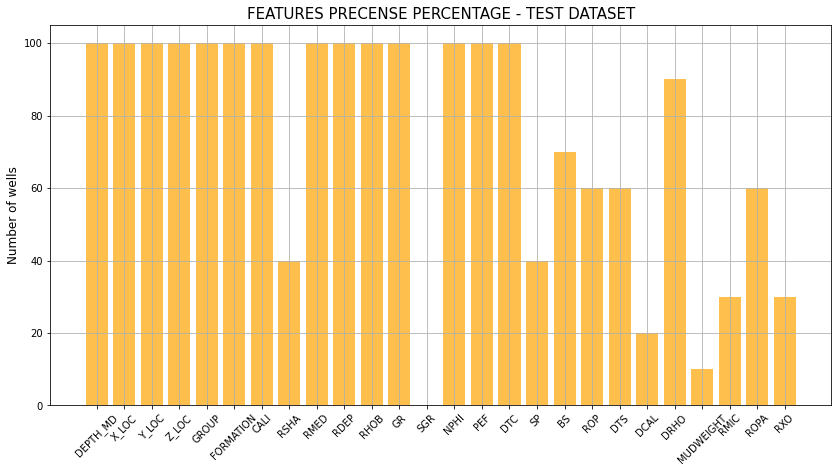

In [ ]:
occurences = np.zeros(26)
for well in test_data['WELL'].unique():
    occurences += test_data[test_data['WELL'] == well].isna().all().astype(int).values[1:-1]
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.bar(x=np.arange(occurences.shape[0]), height=(test_data.WELL.unique().shape[0]-occurences)/test_data.WELL.unique().shape[0]*100.0, color='orange', alpha=0.7)
ax.set_xticklabels(test_data.columns[1:-1], rotation=45)
ax.set_xticks(np.arange(occurences.shape[0]))
ax.set_ylabel('Number of wells', size=12)
ax.set_title("FEATURES PRECENSE PERCENTAGE - TEST DATASET", size=15)
ax.grid()

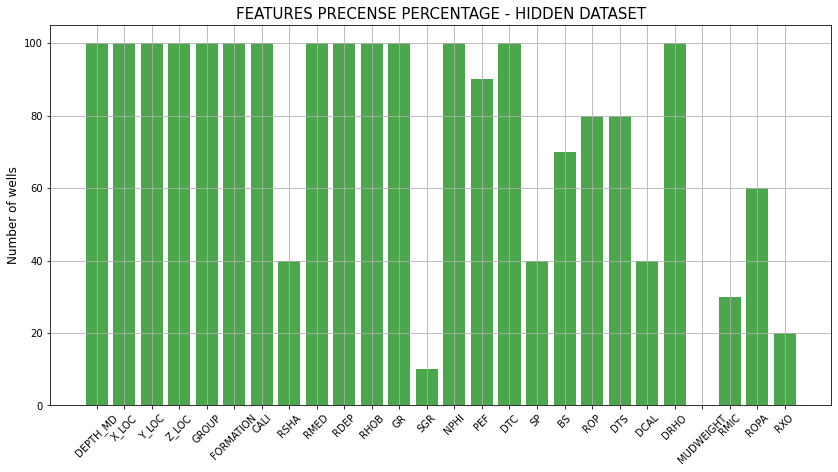

In [ ]:
occurences = np.zeros(26)
for well in hidden_data['WELL'].unique():
    occurences += hidden_data[hidden_data['WELL'] == well].isna().all().astype(int).values[1:-1]
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.bar(x=np.arange(occurences.shape[0]), height=(hidden_data.WELL.unique().shape[0]-occurences)/hidden_data.WELL.unique().shape[0]*100.0, color='green', alpha=0.7)
ax.set_xticklabels(hidden_data.columns[1:-1], rotation=45)
ax.set_xticks(np.arange(occurences.shape[0]))
ax.set_ylabel('Number of wells', size=12)
ax.set_title("FEATURES PRECENSE PERCENTAGE - HIDDEN DATASET", size=15)
ax.grid()

## **3. DATA ANALYSIS AND STATISTICS OVERVIEW**

### 3A. Pairplot

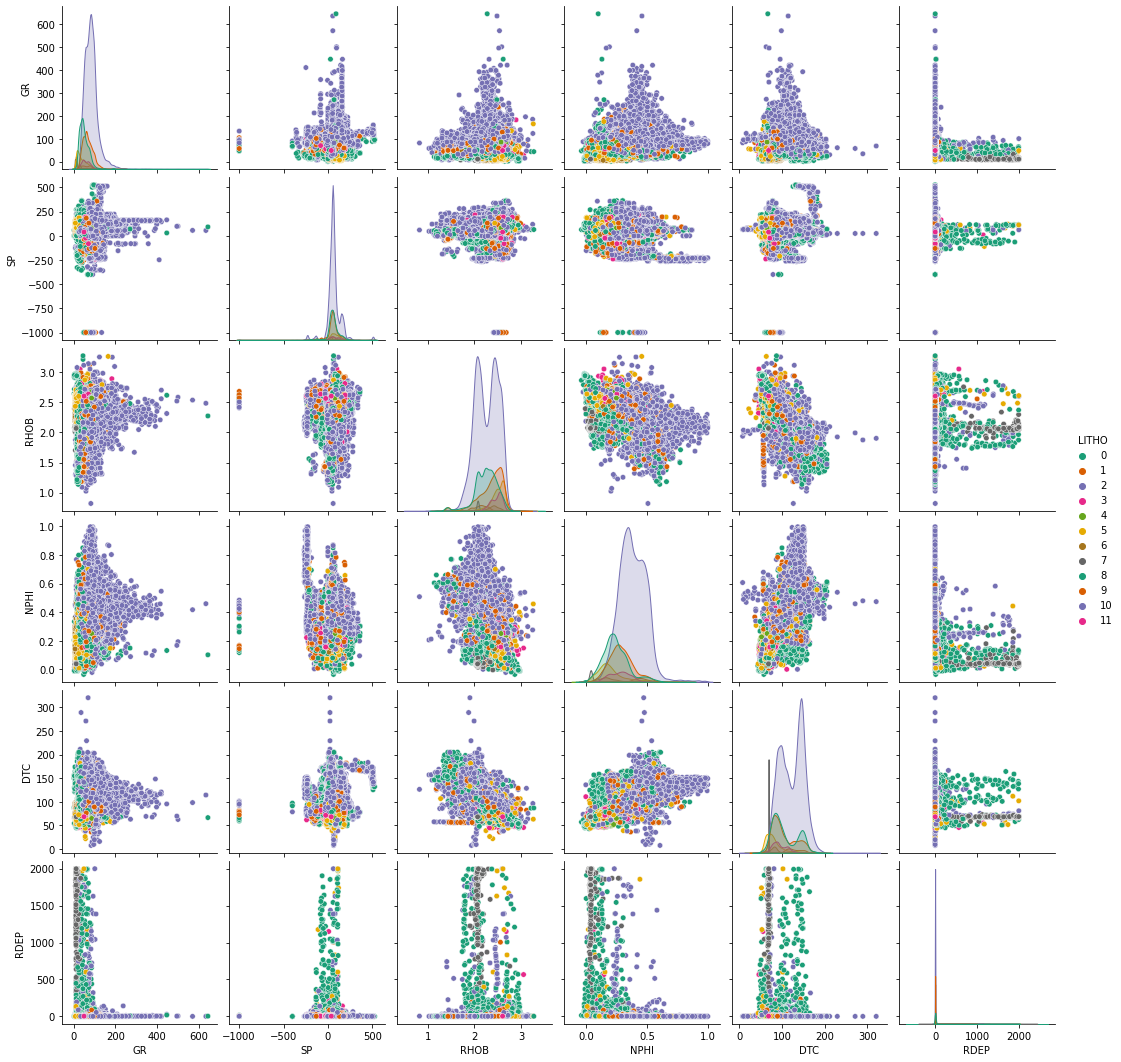

In [ ]:
from sklearn.model_selection import train_test_split

#Sampling training data to speed up plotting
x_sample, x_train_start2, y_sample, y_train_strat2 = train_test_split(labeled_data.drop(['LITHO'], axis=1), labeled_data['LITHO'], train_size=0.1, shuffle=True, stratify=labeled_data.LITHO)
data_sample = pd.concat([x_sample, y_sample], axis=1) #concatenate samples

#Plotting pairplot
sns.pairplot(data_sample, vars=['GR', 'SP', 'RHOB', 'NPHI', 'DTC', 'RDEP'], palette='Dark2', 
             hue='LITHO', diag_kind='kde', plot_kws = {'alpha': 1, 's': 30, 'marker':'o'})

### 3B. Box Plots

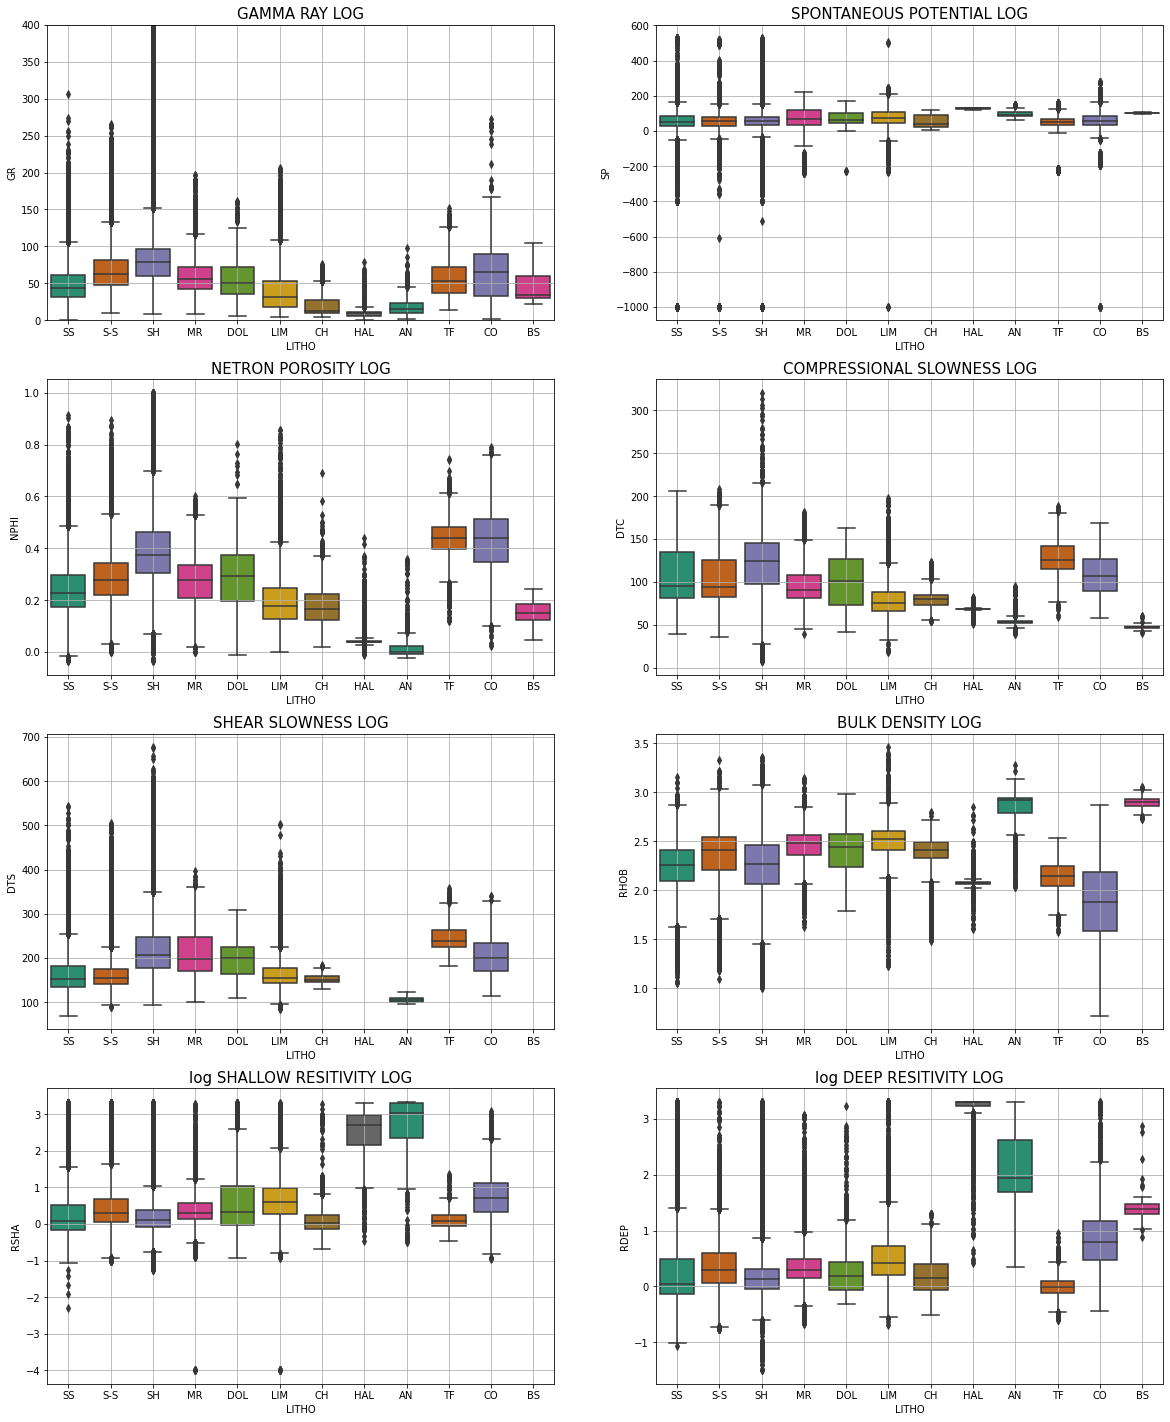

In [ ]:
facies_labels = ['SS', 'S-S', 'SH', 'MR', 'DOL','LIM', 'CH','HAL', 'AN', 'TF', 'CO', 'BS']

plt.figure(figsize=(20,25))

plt.subplot(4,2,1)
sns.boxplot(y='GR', x='LITHO',data=labeled_data, palette='Dark2')
plt.xticks(np.sort(labeled_data.LITHO.unique()), facies_labels)
plt.title('GAMMA RAY LOG', size=15)
plt.ylim(0, 400)
plt.grid()

plt.subplot(4,2,2)
sns.boxplot(y='SP', x='LITHO',data=labeled_data, palette='Dark2' )
plt.xticks(np.sort(labeled_data.LITHO.unique()), facies_labels)
plt.title('SPONTANEOUS POTENTIAL LOG', size=15)
#plt.ylim(0, 400)
plt.grid()

plt.subplot(4,2,3)
sns.boxplot(y='NPHI', x='LITHO',data=labeled_data, palette='Dark2' )
plt.xticks(np.sort(labeled_data.LITHO.unique()), facies_labels)
plt.title('NETRON POROSITY LOG', size=15)
#plt.ylim(0, 400)
plt.grid()

plt.subplot(4,2,4)
sns.boxplot(y='DTC', x='LITHO',data=labeled_data, palette='Dark2' )
plt.xticks(np.sort(labeled_data.LITHO.unique()), facies_labels)
plt.title('COMPRESSIONAL SLOWNESS LOG', size=15)
#plt.ylim(0, 400)
plt.grid()

plt.subplot(4,2,5)
sns.boxplot(y='DTS', x='LITHO',data=labeled_data, palette='Dark2' )
plt.xticks(np.sort(labeled_data.LITHO.unique()), facies_labels)
plt.title('SHEAR SLOWNESS LOG', size=15)
#plt.ylim(0, 400)
plt.grid()

plt.subplot(4,2,6)
sns.boxplot(y='RHOB', x='LITHO',data=labeled_data, palette='Dark2' )
plt.xticks(np.sort(labeled_data.LITHO.unique()), facies_labels)
plt.title('BULK DENSITY LOG', size=15)
#plt.ylim(0, 400)
plt.grid()

plt.subplot(4,2,7)
sns.boxplot(y=np.log10(labeled_data['RSHA']), x=labeled_data['LITHO'], palette='Dark2' )
plt.xticks(np.sort(labeled_data.LITHO.unique()), facies_labels)
plt.title('log SHALLOW RESITIVITY LOG', size=15)
#plt.ylim(0, 50)
plt.grid()

plt.subplot(4,2,8)
sns.boxplot(y=np.log10(labeled_data['RDEP']), x=labeled_data['LITHO'], palette='Dark2' )
plt.xticks(np.sort(labeled_data.LITHO.unique()), facies_labels)
plt.title('log DEEP RESITIVITY LOG', size=15)
#plt.ylim(0, 50)
plt.grid()

### 3C. Spearman's Correlation Raw-Data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


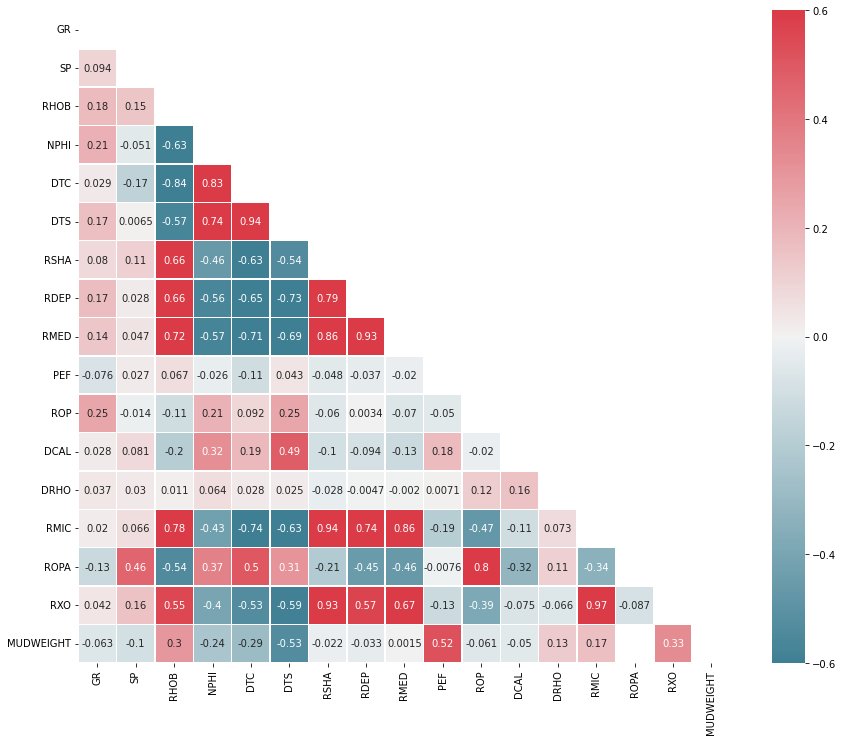

In [ ]:
selected_features_spearman = labeled_data[['GR', 'SP', 'RHOB', 'NPHI', 'DTC', 'DTS', 'RSHA', 'RDEP', 'RMED', 'PEF', 'ROP', 'DCAL', 'DRHO', 'RMIC', 'ROPA', 'RXO', 'MUDWEIGHT']]

# Generate a mask for the upper triangle
mask = np.zeros_like(selected_features_spearman.corr(method = 'spearman') , dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize=(15,12))
sns.heatmap(selected_features_spearman.corr(method = 'spearman') ,annot=True,  mask=mask, cmap=cmap, vmax=0.6, vmin=-0.6, square=True, linewidths=.5)
plt.show()

## **4. SELECTING DATA AND DATA PROCESSING**

### 4A. Dropping unnecesary columns

In [ ]:
#Storing datasets lenghts
train_len = labeled_data.shape[0]
test_len = test_data.shape[0]
hidden_len = hidden_data.shape[0]

#Storing dataset wells and depths
train_well = labeled_data.WELL.values; train_depth = labeled_data.DEPTH_MD.values
test_well = test_data.WELL.values; test_depth = test_data.DEPTH_MD.values
hidden_well = hidden_data.WELL.values; hidden_depth = hidden_data.DEPTH_MD.values

#Concatenating dataset prior to encode
df_concat = pd.concat((labeled_data, test_data, hidden_data)).reset_index(drop=True)

print('Shape of the whole data before dropping and encoding', df_concat.shape)

Shape of the whole data before dropping and encoding (1429694, 28)


### 4B. Encoding Categorical Features

In [ ]:
#Encoding GROUP, FORMATION, and WELL columns
df_concat['GROUP_encoded'] = df_concat['GROUP'].astype('category')
df_concat['GROUP_encoded'] = df_concat['GROUP_encoded'].cat.codes

df_concat['FORMATION_encoded'] = df_concat['FORMATION'].astype('category')
df_concat['FORMATION_encoded'] = df_concat['FORMATION_encoded'].cat.codes

df_concat['WELL_encoded'] = df_concat['WELL'].astype('category')
df_concat['WELL_encoded'] = df_concat['WELL_encoded'].cat.codes

#Dropping 'GROUP' and 'FORMATION' columns
df_drop = df_concat.drop(['GROUP', 'FORMATION', 'SGR', 'ROPA', 'RXO', 'MUDWEIGHT'], axis=1)
print('Shape of the whole data after encoding', df_drop.shape)

Shape of the whole data after encoding (1429694, 25)


In [ ]:
#Splitting concatenated set into training, test, and hidden datasets
traindata = df_drop[:train_len].copy()
testdata = df_drop[train_len:(train_len+test_len)].copy()
hiddendata = df_drop[(train_len+test_len):].copy()

#Cheching datasets shapes before argumentation
print('Training data shape after encoding and dropping unnecesary columns: {}'.format(traindata.shape))
print('Testing data shape after encoding and dropping unnecesary columns: {}'.format(testdata.shape))
print('Hidden data shape after encoding and dropping unnecesary columns: {}'.format(hiddendata.shape))

Training data shape after encoding and dropping unnecesary columns: (1170511, 25)
Testing data shape after encoding and dropping unnecesary columns: (136786, 25)
Hidden data shape after encoding and dropping unnecesary columns: (122397, 25)


### 4C. Feature Engineering (Well log-based features)

In [ ]:
#Train Set
traindata['AI'] = traindata.RHOB * (1e6/traindata.DTS)
traindata['AI_P'] = traindata.RHOB * (1e6/traindata.DTC)
traindata['DT_R'] = traindata.DTC / traindata.DTS
traindata['GM'] = ((1e6/traindata.DTS)**2) * traindata.RHOB
traindata['K'] = (((1e6/traindata.DTC)**2) * traindata.RHOB) - (4 * traindata.GM/3)
traindata['MD_TVD'] = -(traindata.DEPTH_MD/traindata.Z_LOC)

#Test Set
testdata['AI'] = testdata.RHOB * (1e6/testdata.DTS)
testdata['AI_P'] = testdata.RHOB * (1e6/testdata.DTC)
testdata['DT_R'] = testdata.DTC / testdata.DTS
testdata['GM'] = ((1e6/testdata.DTS)**2) * testdata.RHOB
testdata['K'] = (((1e6/testdata.DTC)**2) * testdata.RHOB) - (4 * testdata.GM/3)
testdata['MD_TVD'] = -(testdata.DEPTH_MD/testdata.Z_LOC)

#Hidden Set
hiddendata['AI'] = hiddendata.RHOB * (1e6/hiddendata.DTS)
hiddendata['AI_P'] = hiddendata.RHOB * (1e6/hiddendata.DTC)
hiddendata['DT_R'] = hiddendata.DTC / hiddendata.DTS
hiddendata['GM'] = ((1e6/hiddendata.DTS)**2) * hiddendata.RHOB
hiddendata['K'] = (((1e6/hiddendata.DTC)**2) * hiddendata.RHOB) - (4 * hiddendata.GM/3)
hiddendata['MD_TVD'] = -(hiddendata.DEPTH_MD/hiddendata.Z_LOC)

print('''Training dataset shape after feature engineering: {},
test dataset shape after feature engineering: {},
hidden dataset shape after feature engineering: {}
      '''.format(traindata.shape, testdata.shape, hiddendata.shape))

Training dataset shape after feature engineering: (1170511, 31),
test dataset shape after feature engineering: (136786, 31),
hidden dataset shape after feature engineering: (122397, 31)
      


In [ ]:
#Checking columns
#traindata.columns

### 4D. Missing values imputation (Median)

In [ ]:
#Inputing nan values with median
traindata_filled = traindata.drop(['WELL'], axis=1).apply(lambda x: x.fillna(x.median()), axis=0)
testdata_filled = testdata.drop(['WELL'], axis=1).apply(lambda x: x.fillna(x.median()), axis=0)
hiddendata_filled = hiddendata.drop(['WELL'], axis=1).apply(lambda x: x.fillna(x.median()), axis=0)

In [ ]:
#Checking nan values counts after inputation
traindata_filled.isna().sum()

DEPTH_MD             0
X_LOC                0
Y_LOC                0
Z_LOC                0
CALI                 0
RSHA                 0
RMED                 0
RDEP                 0
RHOB                 0
GR                   0
NPHI                 0
PEF                  0
DTC                  0
SP                   0
BS                   0
ROP                  0
DTS                  0
DCAL                 0
DRHO                 0
RMIC                 0
LITHO                0
GROUP_encoded        0
FORMATION_encoded    0
WELL_encoded         0
AI                   0
AI_P                 0
DT_R                 0
GM                   0
K                    0
MD_TVD               0
dtype: int64

### 4E. Normalization

In [ ]:
#Selecting features to normalize
traindata_filled2 = traindata_filled.drop(traindata_filled[(traindata_filled.RMED < 0)].index)

features_names = traindata_filled2.columns.drop(['LITHO'])

In [ ]:
#Different normalization methods

n = len(features_names)

#Min-Max scaler method
scaler = MinMaxScaler()
x_train_scaled = traindata_filled[features_names].copy()
x_test_scaled = testdata_filled[features_names].copy()
x_hidden_scaled = hiddendata_filled[features_names].copy()

x_train_scaled.iloc[:,:n] = scaler.fit_transform(x_train_scaled.iloc[:,:n])
x_test_scaled.iloc[:,:n] = scaler.transform(x_test_scaled.iloc[:,:n])
x_hidden_scaled.iloc[:,:n] = scaler.transform(x_hidden_scaled.iloc[:,:n])

#Standardization (Z-score Normalization, it is better handling oitliers)
std = StandardScaler()
x_train_std = traindata_filled[features_names].copy()
x_test_std = testdata_filled[features_names].copy()
x_hidden_std = hiddendata_filled[features_names].copy()

x_train_std.iloc[:,:n] = std.fit_transform(x_train_std.iloc[:,:n])
x_test_std.iloc[:,:n] = std.transform(x_test_std.iloc[:,:n])
x_hidden_std.iloc[:,:n] = std.transform(x_hidden_std.iloc[:,:n])

#Normalization
normalizer = Normalizer()
x_train_norm = traindata_filled[features_names].copy()
x_test_norm = testdata_filled[features_names].copy()
x_hidden_norm = hiddendata_filled[features_names].copy()

x_train_norm.iloc[:,:n] = normalizer.fit_transform(x_train_norm.iloc[:,:n])
x_test_norm.iloc[:,:n] = normalizer.transform(x_test_norm.iloc[:,:n])
x_hidden_norm.iloc[:,:n] = normalizer.transform(x_hidden_norm.iloc[:,:n])

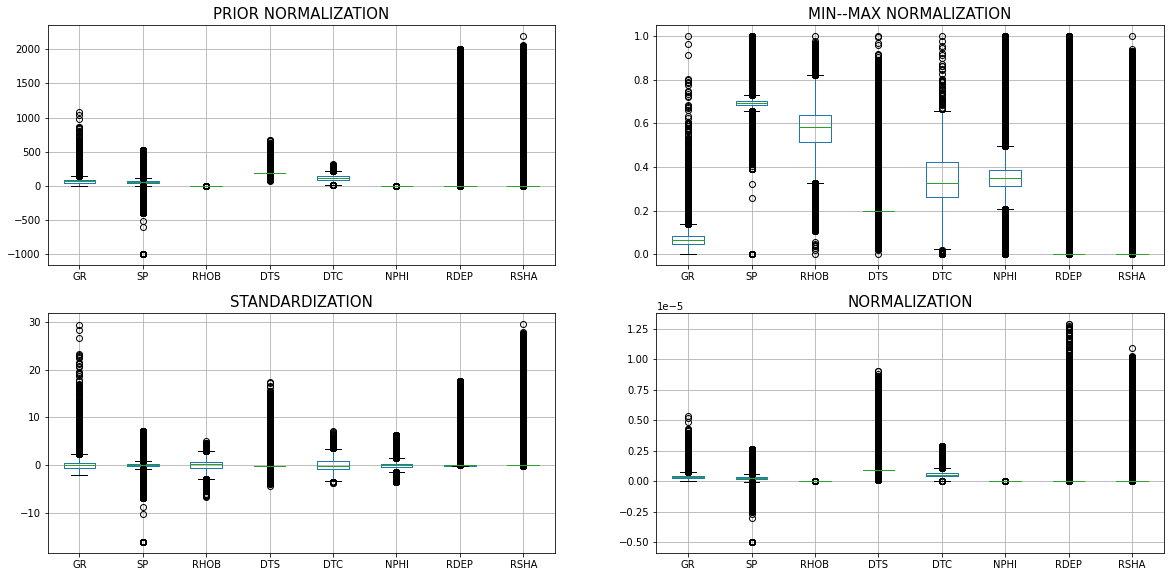

In [ ]:
features_box = ["GR", "SP", "RHOB", "DTS", "DTC", "NPHI", "RDEP", "RSHA"]

plt.figure(figsize=(20,15))

plt.subplot(3,2,1)
traindata_filled2[features_box].boxplot()
plt.title('PRIOR NORMALIZATION', size=15)
plt.grid(True)

plt.subplot(3,2,2)
x_train_scaled[features_box].boxplot()
plt.title('MIN--MAX NORMALIZATION', size=15)
plt.grid(True)

plt.subplot(3,2,3)
x_train_std[features_box].boxplot()
plt.title('STANDARDIZATION', size=15)
plt.grid(True)

plt.subplot(3,2,4)
x_train_norm[features_box].boxplot()
plt.title('NORMALIZATION', size=15)
plt.grid(True)

In [ ]:
#Merging normaslized/standardized, max-min scaled features and labels

traindata_normalized = pd.concat([x_train_std, traindata_filled['LITHO']], axis=1)
test_normalized = pd.concat([x_test_std, testdata_filled['LITHO']], axis=1)
hidden_normalized = pd.concat([x_hidden_std, hiddendata_filled['LITHO']], axis=1)

## **5. MACHINE LEARNING AND DEEP LEARNING IMPLEMENTATION**

**In this section students will have the opportunity to play with the neural network structure and parameters!!**

In [ ]:
#Tensor flow libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam, Adamax


<h1><center>NEURAL NETWORK STRUCTURE</center></h1>

![picture](https://drive.google.com/uc?export=view&id=1qv-Kq3melSxqzqwkbmezWrwBUJEPG5xV)

### 5A. MODEL DESIGN

In [ ]:
#Selected features

# selected_features = ['GROUP_encoded', 'GR', 'NPHI', 'Y_LOC', 'RHOB',
#                       'DEPTH_MD', 'FORMATION_encoded', 'Z_LOC',
#                       'WELL_encoded', 'X_LOC', 'RMED', 'CALI',
#                       'DTC', 'MD_TVD', 'DT_R', 'PEF', 'RDEP',
#                       'DTS', 'GM', 'SP', 'K', 'AI_P', 'DRHO', 'DCAL'
#                     ]

selected_features = ['GR', 'NPHI', 'RHOB',
                      'RMED',
                      'DTC', 'RDEP',
                      'DTS'
                    ]

#Converting features into tensors
x_train_nn = tf.convert_to_tensor(traindata_normalized[selected_features]) ; y_train = traindata_normalized['LITHO']
x_test_nn = tf.convert_to_tensor(test_normalized[selected_features]) ; y_test = test_normalized['LITHO']
x_hidden_nn = tf.convert_to_tensor(hidden_normalized[selected_features]); y_hidden = hidden_normalized['LITHO']

In [ ]:
#Two layer neural network initial hyper-parameters
learning_rate = 0.1
num_nodes = 512
activation = 'sigmoid'

In [ ]:
#Neural Network Structure

opt_model = Sequential()

#Input layer
opt_model.add(InputLayer(input_shape=(x_train_nn.shape[1])))  
opt_model.add(Dropout(0.1))

#1st Hidden Layer
opt_model.add(Dense(num_nodes, activation=activation, kernel_initializer='random_normal'))
opt_model.add(Dropout(0.7))

#2nd Hidden Layer
opt_model.add(Dense(num_nodes, activation=activation, kernel_initializer='random_normal'))

#New hidden layer could be added in here if considered needed
#.
#.
#.
#.

#Output layer
opt_model.add(Dense(12, activation='softmax', kernel_initializer='random_normal'))

#Optimizer
optimizer = SGD(learning_rate=learning_rate, momentum=0.1)

#Model compilation
opt_model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy',  
                  metrics=['accuracy']
                  )
#Early stopping monitor - If loos does not decrease after 50 epoch, the training process will stop.
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, 
                        verbose=1, mode='auto', restore_best_weights=True)

### 5B. TRAINING

In [ ]:
#Fitting and storing losses and accuracy for the training set and validation set

with tf.device('/GPU:0'):          #It can be with '/GPU:0'
  histories = opt_model.fit(x_train_nn, 
                            y_train,
                            batch_size = 256,
                            validation_data = (x_test_nn, y_test),
                            callbacks = [monitor],
                            verbose=1,
                            epochs=50
                            )

Epoch 1/50
4573/4573 [==============================] - 64s 14ms/step - loss: 1.0970 - accuracy: 0.6427 - val_loss: 1.0162 - val_accuracy: 0.6810
Epoch 2/50
4573/4573 [==============================] - 63s 14ms/step - loss: 1.0055 - accuracy: 0.6680 - val_loss: 0.9994 - val_accuracy: 0.6906
Epoch 3/50
4573/4573 [==============================] - 64s 14ms/step - loss: 0.9842 - accuracy: 0.6747 - val_loss: 0.9784 - val_accuracy: 0.6923
Epoch 4/50
4573/4573 [==============================] - 65s 14ms/step - loss: 0.9706 - accuracy: 0.6792 - val_loss: 0.9800 - val_accuracy: 0.6963
Epoch 5/50
4573/4573 [==============================] - 63s 14ms/step - loss: 0.9600 - accuracy: 0.6818 - val_loss: 0.9767 - val_accuracy: 0.7084
Epoch 6/50
4573/4573 [==============================] - 62s 14ms/step - loss: 0.9505 - accuracy: 0.6843 - val_loss: 0.9806 - val_accuracy: 0.7067
Epoch 7/50
4573/4573 [==============================] - 62s 14ms/step - loss: 0.9436 - accuracy: 0.6865 - val_loss: 0.9648 -

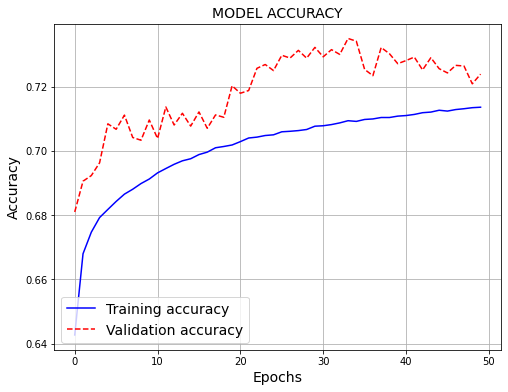

In [ ]:
## Training process visualization (ACCURACY)

fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(histories.history['accuracy'], '-b')
plt.plot(histories.history['val_accuracy'], '--r' )
plt.title('MODEL ACCURACY', size=14)
plt.xlabel('Epochs', size=14)
plt.ylabel('Accuracy', size=14)

plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower left', fontsize=14)
plt.grid(True)
plt.show()

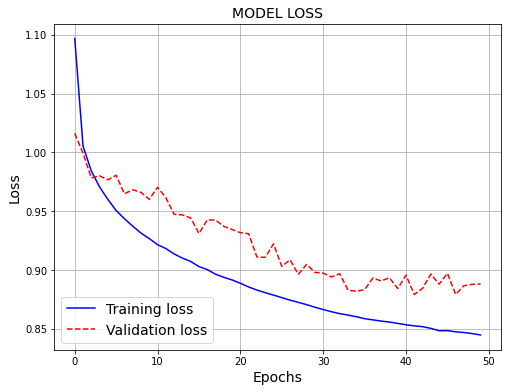

In [ ]:
## Training process visualization (LOSS)

fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(histories.history['loss'], '-b')
plt.plot(histories.history['val_loss'], '--r' )
plt.title('MODEL LOSS', size=14)
plt.xlabel('Epochs', size=14)
plt.ylabel('Loss', size=14)
plt.legend(['Training loss', 'Validation loss'], loc='lower left', fontsize=14)
plt.grid(True)
plt.show()

### 5C. PREDICTIONS

In [ ]:
#Using the trained model to predict - The model predicts probabilities for each clase.
#Hence we must select the class with the highest probability as the most likely class.

nn_train_prob = opt_model.predict(x_train_nn)      
train_nn2 = np.array(pd.DataFrame(nn_train_prob).idxmax(axis=1))

nn_open_prob = opt_model.predict(x_test_nn)
open_nn2 = np.array(pd.DataFrame(nn_open_prob).idxmax(axis=1))

nn_hidden_prob = opt_model.predict(x_hidden_nn)
hidden_nn2 = np.array(pd.DataFrame(nn_hidden_prob).idxmax(axis=1))

In [ ]:
#Predcition reports for the training, test, and hidden sets
from sklearn import metrics

print('-----------------------TRAIN SET REPORT---------------------')
print('Training set report:', metrics.classification_report(y_train, train_nn2))

print('-----------------------OPEN SET REPORT---------------------')
print('Open set report:', metrics.classification_report(y_test, open_nn2))

print('-----------------------HIDDEN SET REPORT---------------------')
print('Hidden set report:', metrics.classification_report(y_hidden, hidden_nn2))

-----------------------TRAIN SET REPORT---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Training set report:               precision    recall  f1-score   support

           0       0.67      0.57      0.62    168937
           1       0.46      0.13      0.21    150455
           2       0.75      0.97      0.85    720803
           3       0.35      0.07      0.12     33329
           4       0.00      0.00      0.00      1688
           5       0.78      0.39      0.52     56320
           6       0.86      0.28      0.42     10513
           7       0.97      0.90      0.93      8213
           8       0.93      0.72      0.81      1085
           9       0.71      0.02      0.04     15245
          10       0.77      0.04      0.07      3820
          11       0.00      0.00      0.00       103

    accuracy                           0.73   1170511
   macro avg       0.60      0.34      0.38   1170511
weighted avg       0.69      0.73      0.68   1170511

-----------------------OPEN SET REPORT---------------------
Open set report:               precision    recall  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **6. PLOTTING PREDICTIONS**

In [ ]:
#Storing results
train_nn_res = labeled_data.copy()
test_nn_res = test_data.copy()
hidden_nn_res = hidden_data.copy()

#Appending predictions to a copy of the original datasets
train_nn_res['NN_TM'] = train_nn2
test_nn_res['NN_TM'] = open_nn2
hidden_nn_res['NN_TM'] = hidden_nn2

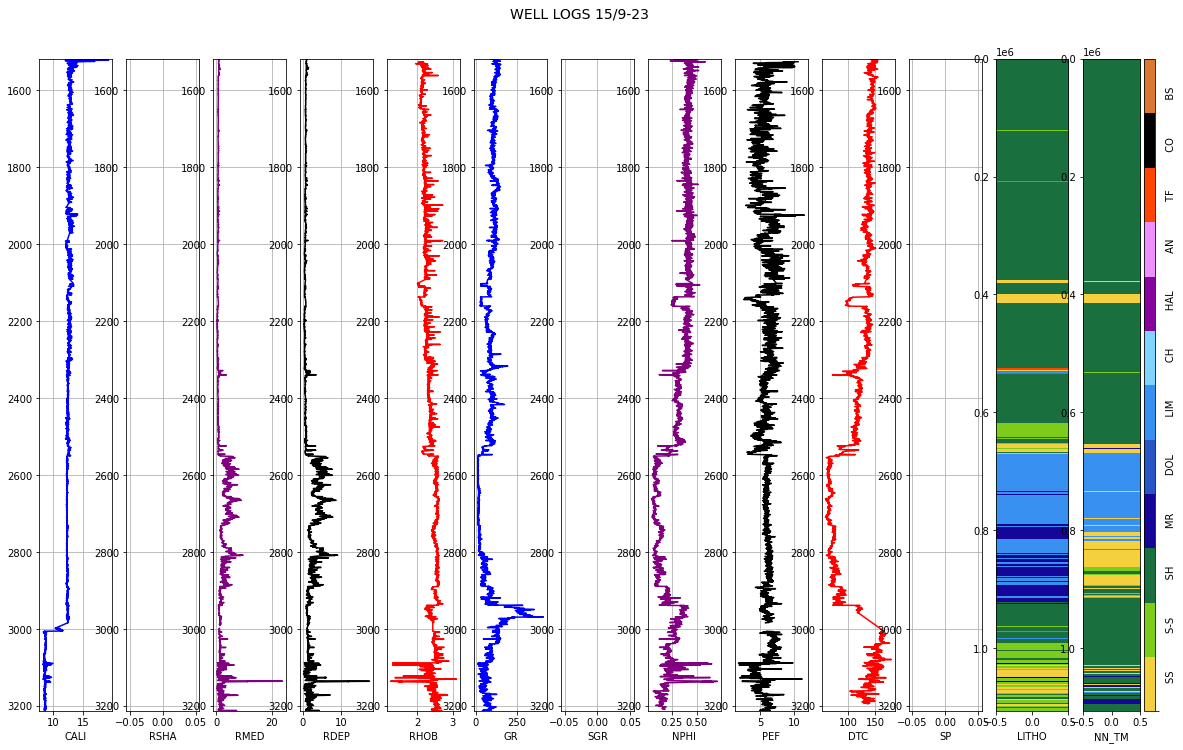

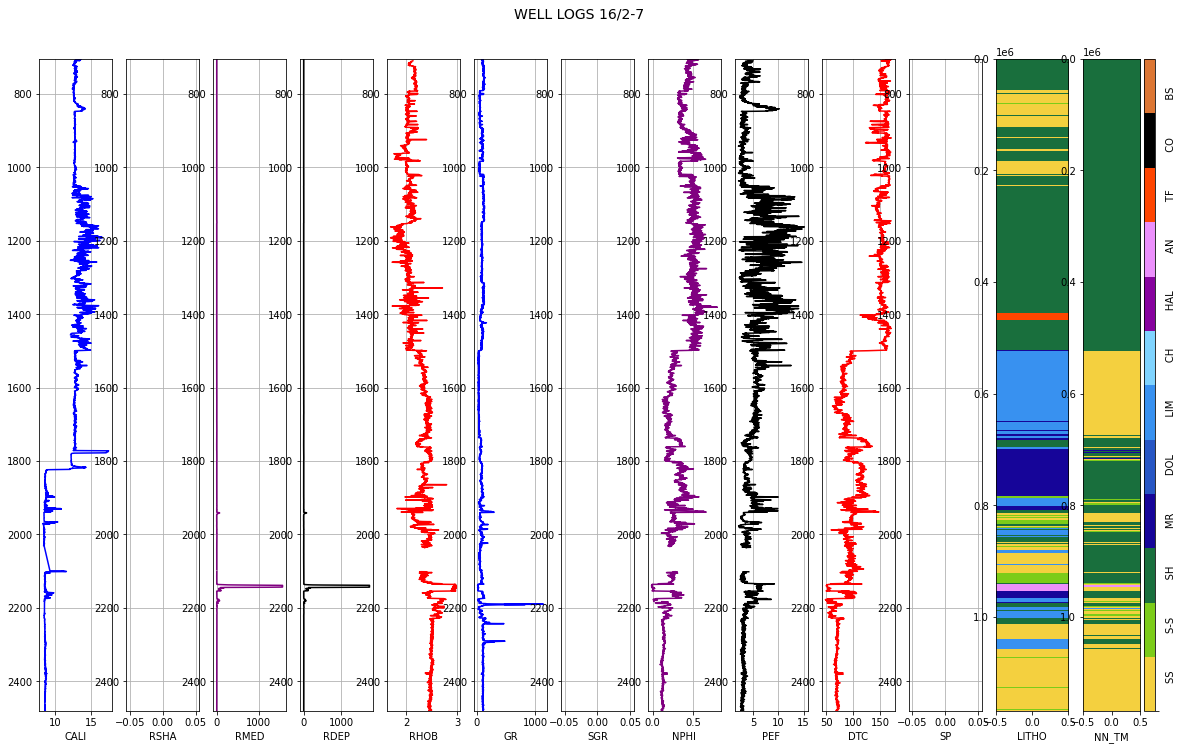

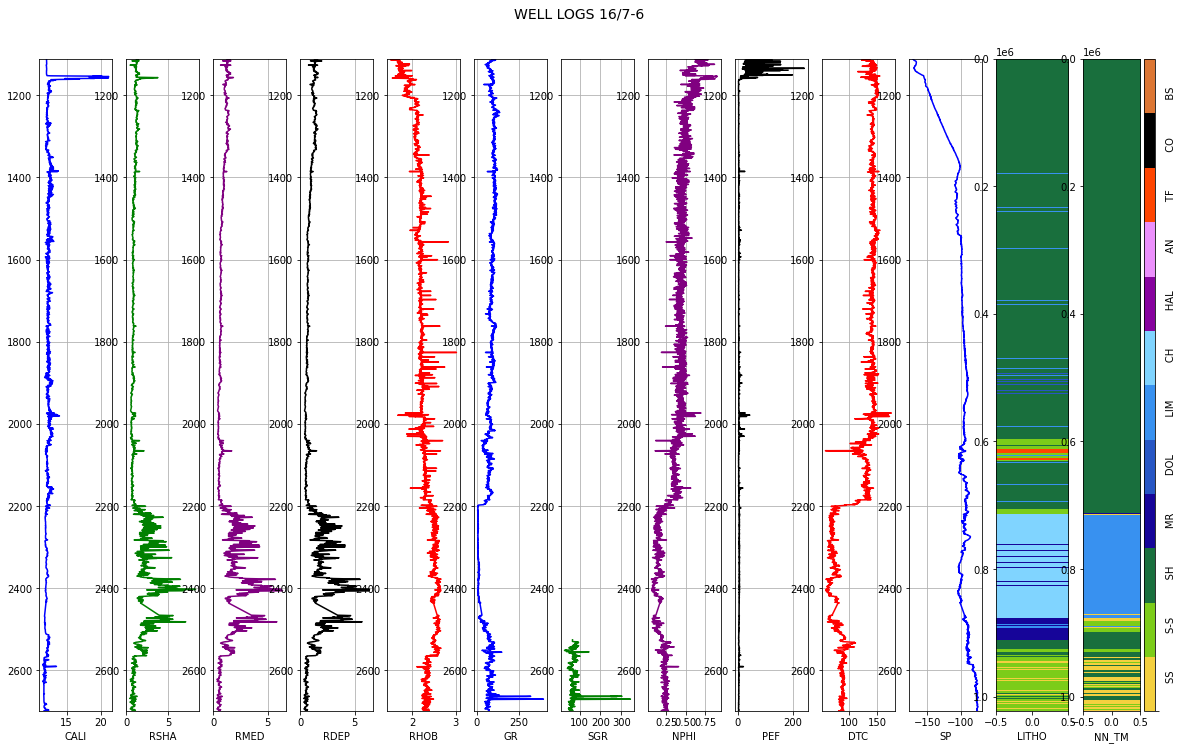

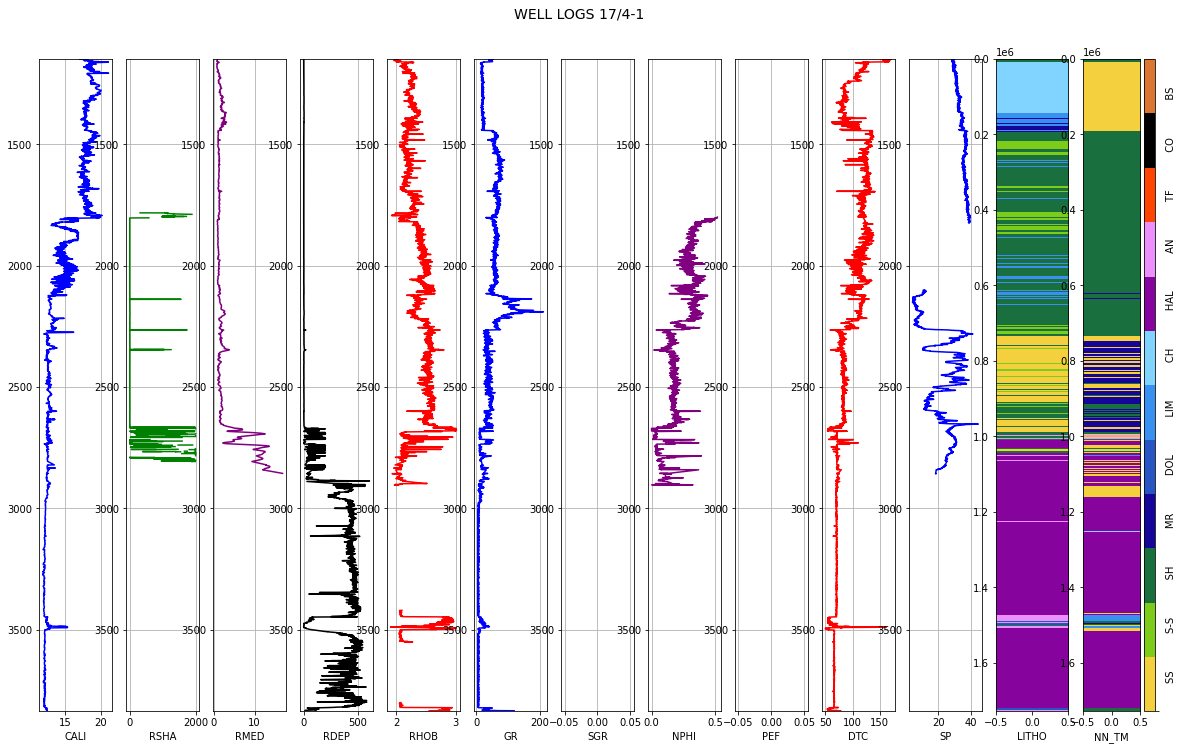

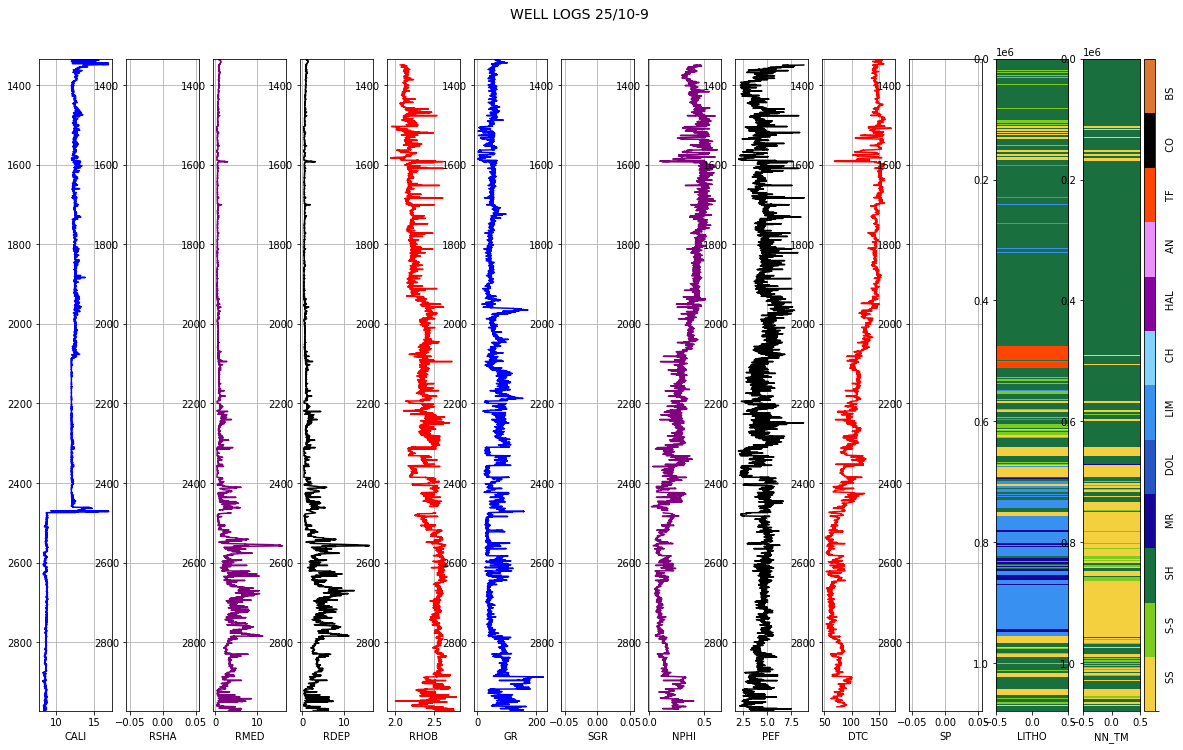

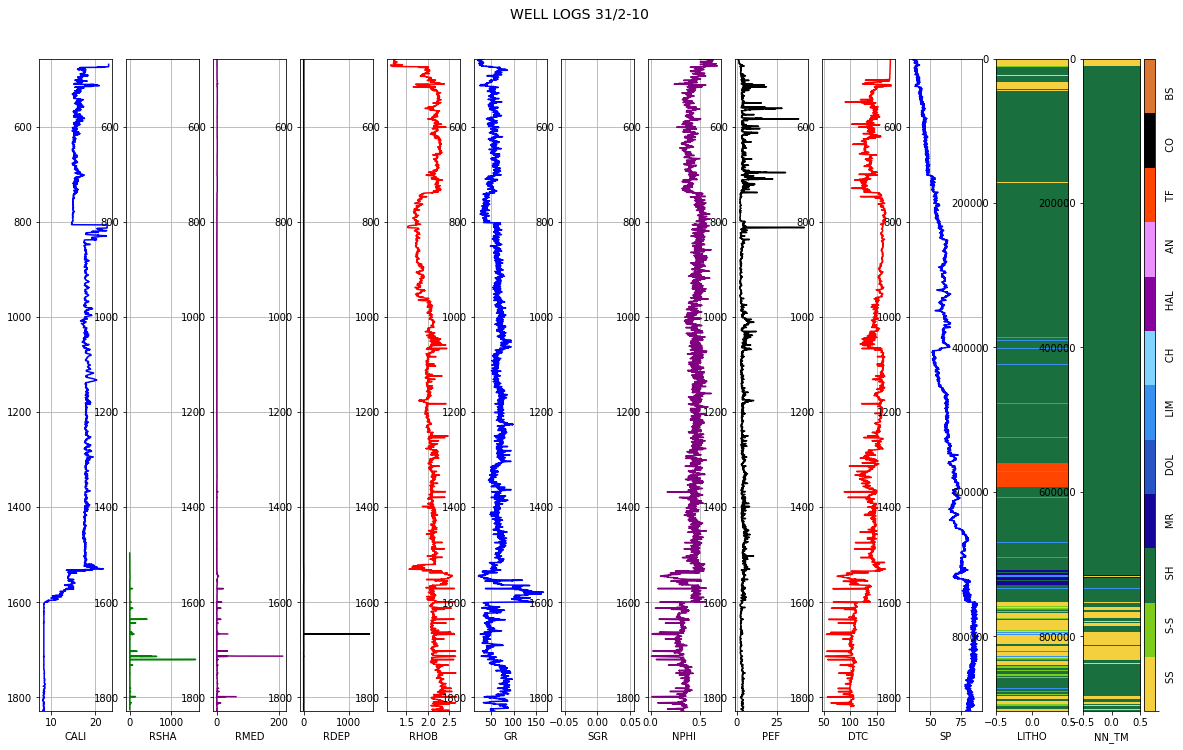

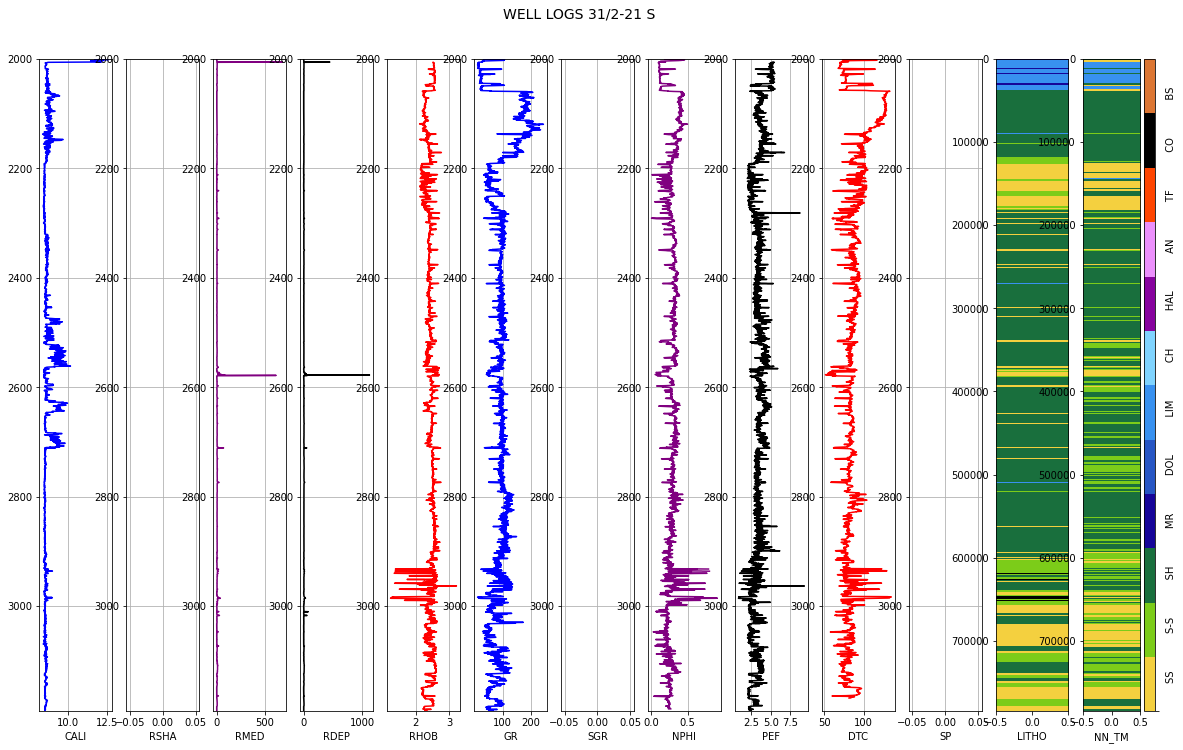

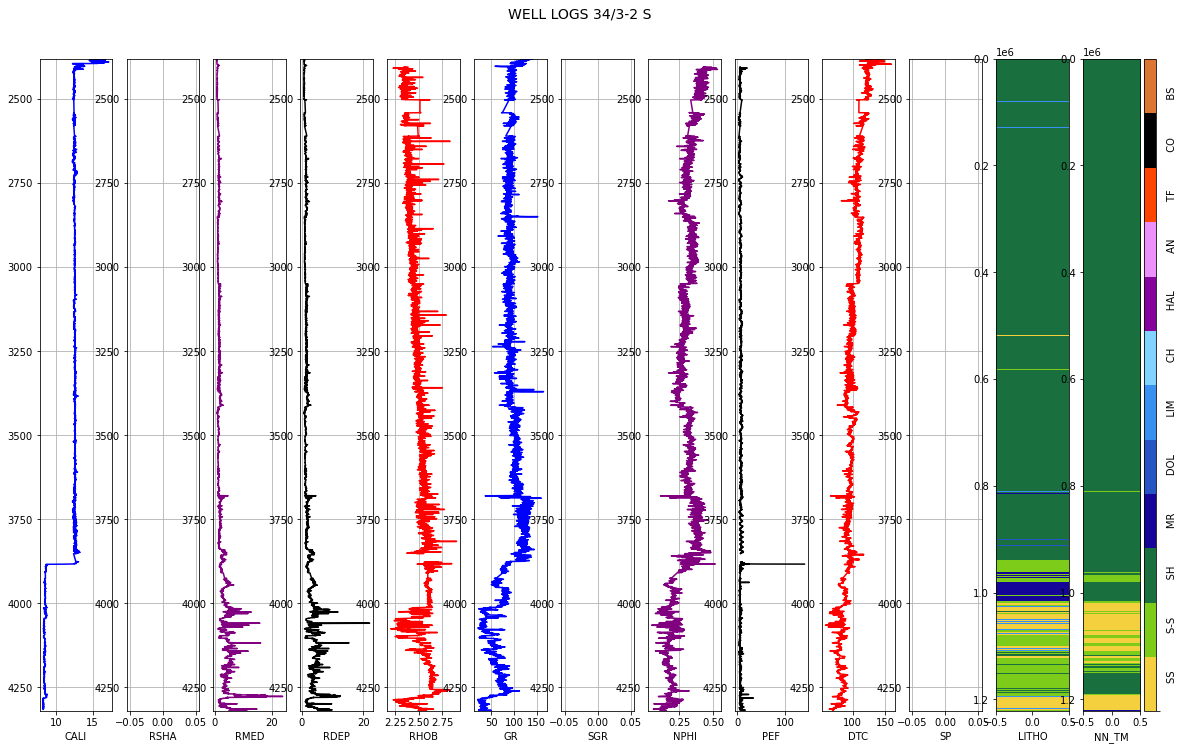

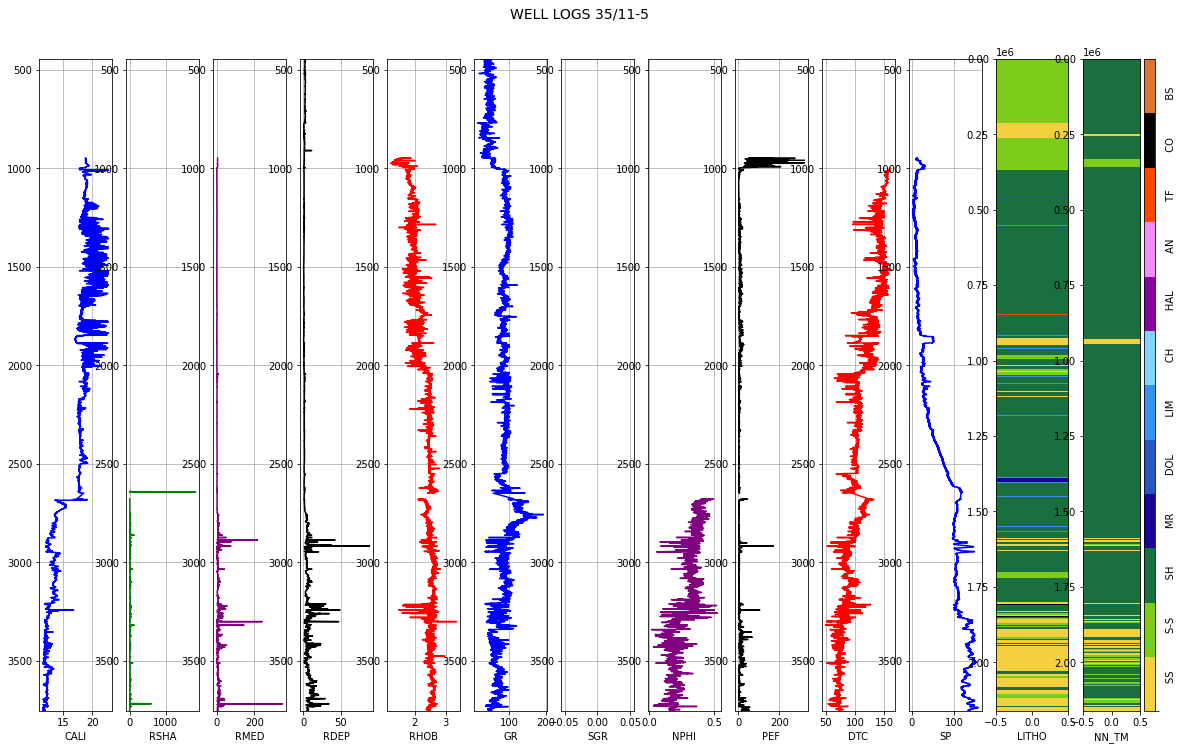

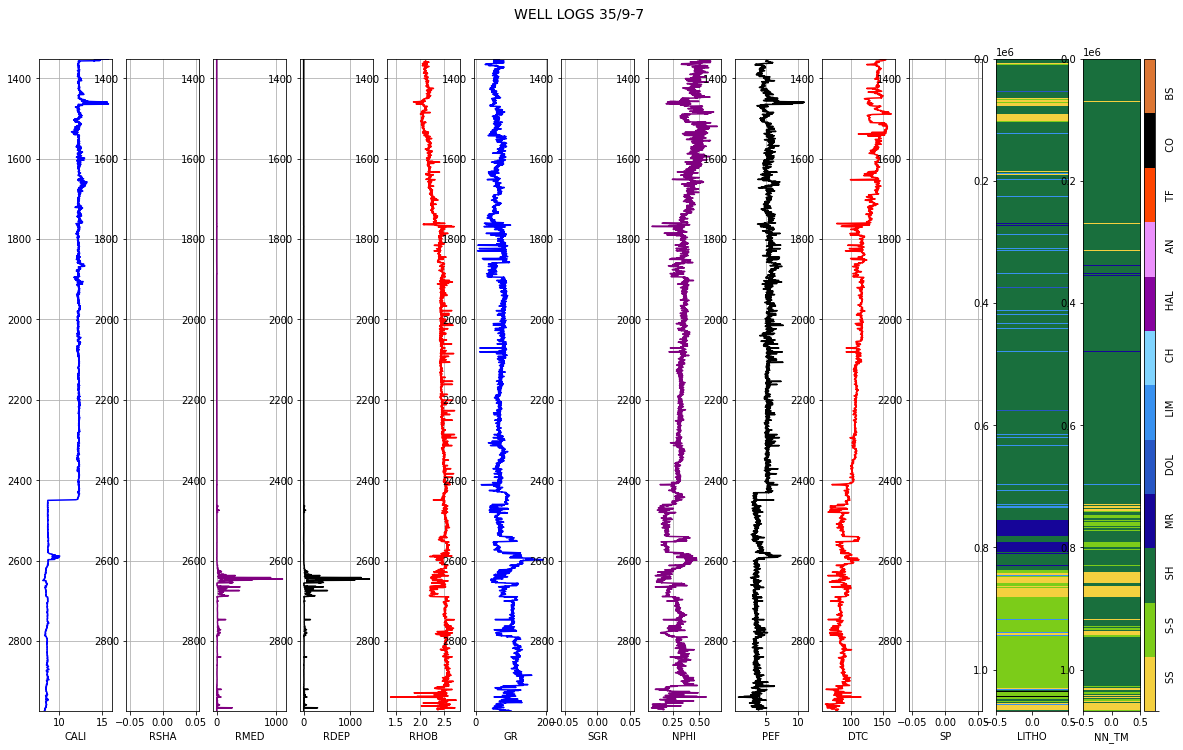

In [ ]:
#Plotting predictions for the hidden dataset
for i in range(10):
  litho_prediction(hidden_nn_res, i, 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:150: RuntimeWarning: invalid value encountered in long_scalars


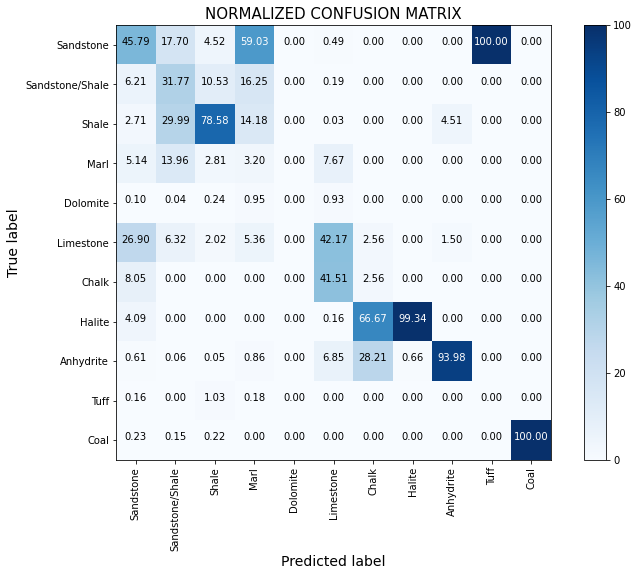

In [ ]:
#Confusion matrix for the hidden dataset
litho_confusion_matrix(hidden_nn_res.LITHO, hidden_nn_res.NN_TM)